# Continuous Time Model Simulating Breast Cancer States

## Introduction
In order to make the model more realistic, it should be possible to transition from one state to another at any time. We therefore simulate a continuous Markov Chain Model with continuous time steps. Still, we simulate 1000 women, all beginning at state 1, and when all have reached state 5, the simulation ends. 
The following program also creates time series containing every womans state at every 48th months (Task 12) as well as calculates the number of women where the cancer have reappered distantly (state 3 or 4) before time step 30.5, and reports the proportion (Task 7). Here we assume, that if a woman has "jumped" from state 1 or 2 directly to state 5, she has not gone through state 3 or 4, and is therefore not included.  

In [2]:
# Initialization
import random
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from numpy.linalg import matrix_power

In [17]:
Q = np.array([[-0.0085, 0.005, 0.0025, 0, 0.001],
              [0, -0.014, 0.005, 0.004, 0.005], 
              [0, 0, -0.008, 0.003, 0.005],
              [0, 0, 0, -0.009, 0.009],
              [0, 0, 0, 0, 0]])

max_state = 5
n_women = 1000
women_states = np.ones(n_women)
time_series_states = np.ones(n_women)
time_series_states_to_4 = np.ones(n_women)
lifetime = np.zeros(n_women)
states = np.arange(1,max_state+1)
time_until_next_state = np.random.exponential(scale = 1/-Q[0][0], size = n_women)
time_passed = 0
counted_positions = np.array([])
state_3_or_4_pos_count = 0

# For examining proportions in specific state after specific time
state_examination = 3
months_examination = 30.5

time_series_point = 48

while np.min(women_states) < max_state:
    
    # Get women that are alive, meaning not in state 5
    women_alive_index = np.where(women_states < 5)[0]

    # Get minimum time until next state, only based on individuals alive
    time_min = np.min(time_until_next_state[women_alive_index])
    time_min_index = np.where((time_until_next_state == time_min))[0]
    time_until_next_state[women_alive_index] = time_until_next_state[women_alive_index] - time_min

    # Update states
    for elem in time_min_index:
        current_state = int(women_states[elem])
        probs = -Q[current_state-1,current_state:]/Q[current_state-1,current_state-1]
        new_state = np.random.choice(states[current_state:], p = probs)
        women_states[elem] = new_state
        
        # Update time only if state is not 5
        if new_state < 5: 
            time_until_next_state[elem] = np.random.exponential(scale = 1/-Q[new_state-1][new_state-1])

    # Update liftime
    lifetime[women_alive_index] += time_min
    
    # Update time passed
    time_passed_before = time_passed
    time_passed += time_min
    
    # Check if less than 30.5 months have passed
    if time_passed <= months_examination:
        # Check if any individuals are in state 3 or 4 and delete them if they are
        state_3_or_4_pos = np.where((women_states == 3) | (women_states == 4))[0]
        new_counts = 0
        
        # Get number of women in state 3/4 but not taking into account positions that have already been counted
        for elem in state_3_or_4_pos:
            if elem not in counted_positions:
                new_counts += 1
        state_3_or_4_pos_count += new_counts

        # Save the positions that have already been counted
        counted_positions = np.unique(np.concatenate((counted_positions, state_3_or_4_pos)))
        
    # Check if 48 months has passed
    if time_passed_before < time_series_point and time_passed >= time_series_point:
        
        # Save time series for all women
        time_series_states = np.vstack((time_series_states, women_states))
        time_series_point += time_series_point

# Check if vector with state 5 in all positions has been added to the time series
if not np.all(time_series_states[-1,:] == max_state):
    time_series_states = np.vstack((time_series_states, women_states))
    
# Transpose time series to have every individual as a row
time_series_states = time_series_states.T
    
print("Women that are/have been in state 3/4 when {} months has passed: {} %".format(months_examination, 100 * state_3_or_4_pos_count/n_women))
print("\n")
print("Time series with 1 row representing the development of 1 individual:")
for row in range(0,10):
    print(time_series_states[row, :])
print("...")

Women that are/have been in state 3/4 when 30.5 months has passed: 8.9 %


Time series with 1 row representing the development of 1 individual:
[1. 1. 1. 1. 5. 5. 5.]
[1. 3. 3. 3. 5. 5. 5.]
[1. 5. 5. 5. 5. 5. 5.]
[1. 2. 4. 5. 5. 5. 5.]
[1. 1. 1. 5. 5. 5. 5.]
[1. 2. 5. 5. 5. 5. 5.]
[1. 1. 1. 5. 5. 5. 5.]
[1. 3. 3. 3. 5. 5. 5.]
[1. 1. 1. 1. 5. 5. 5.]
[1. 3. 5. 5. 5. 5. 5.]
...


From the above, it can be seen that 8.9% of women have gone through state 3/4 when 30.5 months have passed. 
Furthermore a subset (first to tenth row) of the time series is shown. In the first column all women are in state 1 and in last column all women are in state 5. The time series jumps 48 months, meaning that e.g. column 3 represents the women's states at 96th month. 

### Illustration of lifetime distribution
The following illustrates the distribution of the amount of time passing from state 1 to 5. 

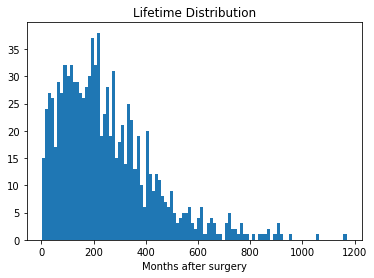

In [4]:
# Illustrate distribution of lifetime
plt.figure()
plt.title("Lifetime Distribution")
plt.xlabel("Months after surgery")
plt.hist(lifetime, bins = 100)
plt.show()

The lifetime distribution show a similar pattern to the life time distribution in the discrete model, being scewed as well. There is still a long right tail, meaning that some people live for an unrealistically long time. 

# Mean and confidence intervals for the lifetime distribution
The mean and standard deviation of lifetime is calculated as well as the confidence intervals of these estimates. 

In [19]:
# Calculate mean and variance
lifetime_mean = np.mean(lifetime)
lifetime_var = np.var(lifetime)
lifetime_sd = np.sqrt(lifetime_var)


CI_lower_mean = lifetime_mean + np.sqrt(lifetime_var)/np.sqrt(n_women) * stats.t.ppf(0.05/2, df =n_women-1)
CI_upper_mean = lifetime_mean + np.sqrt(lifetime_var)/np.sqrt(n_women) * stats.t.ppf(1-0.05/2, df = n_women-1)

print("Mean of lifetime: ", lifetime_mean)
print("Confidence Interval of the mean of lifetime: ", [CI_lower_mean, CI_upper_mean])

print("\n")
CI_lower_sd = np.sqrt((n_women - 1) * lifetime_var/stats.chi2.ppf(1-0.05/2, df =n_women-1))
CI_upper_sd = np.sqrt((n_women - 1) * lifetime_var/stats.chi2.ppf(0.05/2, df =n_women-1))

print("Standard deviation of lifetime: ", lifetime_sd)
print("Confidence Interval of the mean of lifetime: ", [CI_lower_sd, CI_upper_sd])


Mean of lifetime:  261.007775910556
Confidence Interval of the mean of lifetime:  [249.03284600497645, 272.98270581613554]


Standard deviation of lifetime:  192.97382271393215
Confidence Interval of the mean of lifetime:  [184.8713052178368, 201.8246360610568]


As can be seen, the mean lifetime is around 261 months, with a confidence interval corresponding to around +/- a year, which is relatively narrow. The mean standard deviation is around 193 months, and here the confidence interval is relatively narrow as well. 

# Task 13: Estimation

In this task, we try to estimate the matrix Q based on available data about the cancer states of the women collected every 48th month. Because the data is collected with a large time interval, we don't know which states the women have gone through between the data collections. This information is needed to estimate the matrix Q. Therefore, we simulate state trajectories for each woman and compare the result with the data (as produced in task 12) in order to get data to work from. We start out with a guess for Q, and then simulate the trajectories as described in the project description by rejecting all trajectories that do not match the given data. This is then used to update Q until barely no changes happen with Q.

In [18]:
# Test women
X = time_series_states.astype(int)
#np.array([[1,2,3,4,5],
#              [1,3, 3, 3, 5],
#              [1, 2, 2, 4, 5],
#              [1, 2, 3, 3, 5],
#              [1, 4, 4, 5, 5]])

#X = np.array([[1,2,3,4,5],
#              [1,3, 3, 3, 5]])

# Initial Q guess
#Q_test = np.array([[-0.004, 0.001, 0.001, 0.001, 0.001],
#              [0, -0.003, 0.001, 0.001, 0.001], 
#              [0, 0, -0.002, 0.001, 0.001],
#              [0, 0, 0, -0.001, 0.001],
#              [0, 0, 0, 0, 0]]) 

Q_test = np.array([[-0.008, 0.004, 0.002, 0, 0.002],
              [0, -0.015, 0.005, 0.005, 0.005], 
              [0, 0, -0.008, 0.004, 0.004],
              [0, 0, 0, -0.007, 0.007],
              [0, 0, 0, 0, 0]])

# Possible states
states = np.arange(1,6)


# N and S (for filling out)
N = np.array([[0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0], 
              [0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0]]) 

S = np.zeros(4)

# Initial trajectory matrix
X_test = np.zeros(np.shape(X)[1] * 48)

k = 0

diff = 1

# K LOOP
while diff >= 10**(-3):
     
    # N and S
    N = np.array([[0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0], 
                  [0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0]]) 
    S = np.zeros(4)
    
    # PART 1: WOMAN LOOP
    for i in range(len(X)):
        # Get woman
        test_woman = X[i,:]
        woman_all_states = np.array([])
        woman_event_times = np.array([])
    
        t = np.array([])
        
        j = 0
        # Run through woman: ONE-WOMAN LOOP
        while j < len(test_woman)-1:
            y_start = test_woman[j]
            y_end = test_woman[j+1]
            
            try_state = np.array([y_start])
            if try_state[-1] < 5:
                try_t = np.array([np.random.exponential(scale = 1/-Q_test[try_state[-1]-1, try_state[-1]-1])])
            else:
                break
            
            # TRY LOOP
            while (np.sum(t) + np.sum(try_t)) < ((j+1)*48):
                # Get new state
                probs = -Q_test[try_state[-1] - 1, try_state[-1]:]/Q_test[try_state[-1] - 1, try_state[-1] - 1]
                addition_for_try_state = np.array([np.random.choice(states[try_state[-1]:], p = probs)])
                try_state = np.concatenate((try_state, addition_for_try_state))
                
                # Get time for state
                if try_state[-1] < 5:
                    addition_for_try_t = np.array([np.random.exponential(scale = 1/-Q_test[try_state[-1]-1,try_state[-1]-1])])
                    try_t = np.concatenate((try_t, addition_for_try_t))
                         
                else:
                    break
             
                                             
            # ACCEPTANCE OR REJECTION
            if try_state[-1] == y_end:
                if np.sum(t) + np.sum(try_t) < ((j+2)*48):
                    t = np.concatenate((t, try_t))
                    woman_all_states = np.concatenate((woman_all_states, try_state))
                    j += 1
                    
                else:
                    how_many_intervals = int(np.floor((np.sum(t) + np.sum(try_t))/48))
                    if (j + how_many_intervals < len(test_woman)):
                        if (test_woman[j + how_many_intervals] == try_state[-1]):
                            t = np.concatenate((t, try_t))
                            woman_all_states = np.concatenate((woman_all_states, try_state))
                            j += how_many_intervals
                        
                        
        # Calculate N
        for w in range(len(woman_all_states)-1):
            i = int(woman_all_states[w] - 1)
            j = int(woman_all_states[w+1] - 1)
            if i != j:
                N[i,j] += 1
            
        # Calculate S
        for w in range(1,5):
            S[w-1] += np.sum(t[np.where(woman_all_states == w)[0]])
            
    ### Create Q ###
    Q_simulation = np.array([[0.0, 0.0, 0.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0], 
              [0.0, 0.0, 0.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0]])
    
    for i in range(4):
        for j in range(5):
            if S[i] != 0:
                entrance = N[i,j]/S[i]
                Q_simulation[i][j] += entrance
                Q_simulation[i,j] += N[i,j]/S[i]
    
    # Make sure each row sums to 0
    for i in range(5):
        for j in range(5):
            if i == j:
                Q_simulation[i, j] = -np.sum(Q_simulation[i,j+1:])
    
    ### Find diff ###
    diff_matrix = Q_test - Q_simulation
    diff = np.linalg.norm(diff_matrix, np.inf)
    Q_test = np.copy(Q_simulation)
    print(diff)
    

print('Done. Final Q-matrix:')
print(Q_test)

0.06466005388209647
0.023402489256466194
0.013498835283471993
0.016237675460076054
0.016901569113618453
0.01870746569614609
0.0055861375736840635
0.008079647077401442
0.00807264055252263
0.012096791401736558
0.014297492312650234
0.009587936951593443
0.010694620014608774
0.004300260206413211
0.009089137489798657
0.010863639989227097
0.019423789210951503
0.007535715666779279
0.011049368530012352
0.005142015775307315
0.006454512918370098
0.009592252707687293
0.0063899395524807945
0.00897917914850166
0.0051423721391376616
0.00816637820219418
0.004699149398049619
0.004019952495102785
0.024820485778692114
0.0043488282957542986
0.013679338440998001
0.005676352547586638
0.006229599234508015
0.006083912622905091
0.00665921359821486
0.022640480682126707
0.010323557209969525
0.010134803796961873
0.0009032579640239069
Done. Final Q-matrix:
[[-0.02075235  0.01614532  0.00128665  0.          0.00332038]
 [ 0.         -0.08759212  0.07757194  0.00743069  0.00258948]
 [ 0.          0.         -0.05705

Above, we have printed the differences for each k'th iteration, and the final Q-matrix, once the matrix norm of $Q^{(k)}$ and $Q^{(k+1)}$ was below $10^{-3}$. As can be seen, we reach that no woman will go from state 1 to 4, and otherwise the rates are generally higher than for the original given Q. 